# Project 5: Identifying High Risk Areas from NYC Traffic Conditions
## *Template Notebook*

In this notebook:

* [Topic 1](#topic-1)
* [Topic 2](#topic-2)

#### Import Libraries & Read in Data

In [2]:
## standard imports 
import pandas as pd 
import numpy as np
import re
## visualizations
import matplotlib.pyplot as plt
import seaborn as sns
## preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.dummy import DummyClassifier
## modeling
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import MultinomialNB
## trees
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier, ExtraTreesClassifier, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, AdaBoostClassifier, GradientBoostingRegressor
## NLP
from sklearn.feature_extraction.text import CountVectorizer
## analysis
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, make_scorer, f1_score, mean_squared_error

## options
import sklearn
pd.options.display.max_rows = 4000
pd.options.display.max_columns = 100
pd.set_option('max_colwidth', 100)

In [3]:
### read in data
data = pd.read_csv('../data_large/selected_data.csv')

Trimmed data from https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Vehicles/bm4k-52h4

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150196 entries, 0 to 1150195
Data columns (total 14 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Unnamed: 0              1150196 non-null  int64  
 1   ID                      1150196 non-null  int64  
 2   SPEED                   1150196 non-null  float64
 3   TRAVEL_TIME             1150196 non-null  int64  
 4   STATUS                  1150196 non-null  int64  
 5   DATA_AS_OF              1150196 non-null  object 
 6   LINK_ID                 1150196 non-null  int64  
 7   LINK_POINTS             1150196 non-null  object 
 8   ENCODED_POLY_LINE       1150196 non-null  object 
 9   ENCODED_POLY_LINE_LVLS  1150196 non-null  object 
 10  OWNER                   1150196 non-null  object 
 11  TRANSCOM_ID             1150196 non-null  int64  
 12  BOROUGH                 1150196 non-null  object 
 13  LINK_NAME               1150196 non-null  object 
dtypes:

In [67]:
data.shape

(1150196, 14)

In [68]:
data.head()

,Unnamed: 0,ID,SPEED,TRAVEL_TIME,STATUS,DATA_AS_OF,LINK_ID,LINK_POINTS,ENCODED_POLY_LINE,ENCODED_POLY_LINE_LVLS,OWNER,TRANSCOM_ID,BOROUGH,LINK_NAME
0,1674431,315,49.08,101,0,2019-05-20 19:29:13,4616364,"40.73744001,-73.85188001 40.737015,-73.85373001 40.73673,-73.85543001 40.736526,-73.85631001 ...",_pswFfewaMtApJv@rIh@nDlFbXhH`]bJla@|@`FbHz\fBvG,BBBBBBBBBB,NYC_DOT_LIC,4616364,Queens,LIE W 108TH ST - 84TH ST
1,1674412,258,34.79,122,0,2019-05-20 19:29:13,4616220,"40.6162405,-74.02612 40.61923,-74.02361 40.62362,-74.019831 40.6248406,-74.019061 40.62579,-74.0...",oz{vFffybMuQuNmZsVsFyC}D}AeLmDeO_E{JkCaEg@,BBBBBBBBB,NYC_DOT_LIC,4616220,Brooklyn,GOW N 92ND STREET - 7TH AVENUE
2,1674410,382,0.00,0,-101,2019-05-20 19:29:13,4616216,"40.63089,-74.14569 40.6298,-74.14569 40.62883,-74.14556 40.62805,-74.145451 40.6272105,-74.14546...",av~vFpqpcMxE?`EYzCUfD@|CZtDdAnCd@`Cz@rCdAzCzAvDlCzNlNfEfEbChBhD~AjJnBnVzDtA]|@cBD_Bq@qAaBD,BBBBBBBBBBBBBBBBBBBBBBB,NYC_DOT_LIC,4616216,Staten Island,SIE E-MLK N RICHMOND AVENUE - WALKER STREET
3,1674409,388,52.81,54,0,2019-05-20 19:29:13,4616211,"40.6151706,-74.15738 40.61739,-74.16056 40.6205405,-74.16683 40.6209604,-74.16791 40.6210504,-74...",ys{vFrzrcM{LzRuRdf@sAvEQv@[lB,BBBBBB,NYC_DOT_LIC,4616211,Staten Island,SIE W RICHMOND AVENUE - SOUTH AVENUE
4,1674408,351,0.00,0,-101,2019-05-20 19:29:13,4616210,"40.63092,-74.14592 40.62975,-74.14593 40.62877,-74.14579 40.6279506,-74.145671 40.62713,-74.1456...",gv~vF~rpcMhF@bE[bDWbD@vCb@|D~@dCf@`Cv@jCjA~CzAhDfCrDjDfJ~IhDhDxB~AlDlBdEdArDp@jC|Bt@zBCjDeB~DgAzA,BBBBBBBBBBBBBBBBBBBBBBBB,NYC_DOT_LIC,4616210,Staten Island,MLK S - SIE W WALKER STREET - RICHMOND AVENUE


Notes on data:

* ID and LINK_ID are the same (according to the data dictionary) Drop one of these (I say ID so LINK_ID is easy to associate to LINK_POINTS
* Says both STATUS and TRANSCOM_ID are not useful (artifacts) -- drop these
* TRAVEL_TIME - units? -- drop
* Unnamed: 0 -- need to remove index from data set when export to csv



In [42]:
data.columns

Index(['Unnamed: 0', 'ID', 'SPEED', 'TRAVEL_TIME', 'STATUS', 'DATA_AS_OF',
       'LINK_ID', 'LINK_POINTS', 'ENCODED_POLY_LINE', 'ENCODED_POLY_LINE_LVLS',
       'OWNER', 'TRANSCOM_ID', 'BOROUGH', 'LINK_NAME'],
      dtype='object')

In [69]:
drop_cols = ['Unnamed: 0', 'ID', 'TRAVEL_TIME', 'STATUS',
       'OWNER', 'TRANSCOM_ID', ]
data.drop(columns=drop_cols, axis=1, inplace=True)

In [70]:
data.head()

,SPEED,DATA_AS_OF,LINK_ID,LINK_POINTS,ENCODED_POLY_LINE,ENCODED_POLY_LINE_LVLS,BOROUGH,LINK_NAME
0,49.08,2019-05-20 19:29:13,4616364,"40.73744001,-73.85188001 40.737015,-73.85373001 40.73673,-73.85543001 40.736526,-73.85631001 ...",_pswFfewaMtApJv@rIh@nDlFbXhH`]bJla@|@`FbHz\fBvG,BBBBBBBBBB,Queens,LIE W 108TH ST - 84TH ST
1,34.79,2019-05-20 19:29:13,4616220,"40.6162405,-74.02612 40.61923,-74.02361 40.62362,-74.019831 40.6248406,-74.019061 40.62579,-74.0...",oz{vFffybMuQuNmZsVsFyC}D}AeLmDeO_E{JkCaEg@,BBBBBBBBB,Brooklyn,GOW N 92ND STREET - 7TH AVENUE
2,0.00,2019-05-20 19:29:13,4616216,"40.63089,-74.14569 40.6298,-74.14569 40.62883,-74.14556 40.62805,-74.145451 40.6272105,-74.14546...",av~vFpqpcMxE?`EYzCUfD@|CZtDdAnCd@`Cz@rCdAzCzAvDlCzNlNfEfEbChBhD~AjJnBnVzDtA]|@cBD_Bq@qAaBD,BBBBBBBBBBBBBBBBBBBBBBB,Staten Island,SIE E-MLK N RICHMOND AVENUE - WALKER STREET
3,52.81,2019-05-20 19:29:13,4616211,"40.6151706,-74.15738 40.61739,-74.16056 40.6205405,-74.16683 40.6209604,-74.16791 40.6210504,-74...",ys{vFrzrcM{LzRuRdf@sAvEQv@[lB,BBBBBB,Staten Island,SIE W RICHMOND AVENUE - SOUTH AVENUE
4,0.00,2019-05-20 19:29:13,4616210,"40.63092,-74.14592 40.62975,-74.14593 40.62877,-74.14579 40.6279506,-74.145671 40.62713,-74.1456...",gv~vF~rpcMhF@bE[bDWbD@vCb@|D~@dCf@`Cv@jCjA~CzAhDfCrDjDfJ~IhDhDxB~AlDlBdEdArDp@jC|Bt@zBCjDeB~DgAzA,BBBBBBBBBBBBBBBBBBBBBBBB,Staten Island,MLK S - SIE W WALKER STREET - RICHMOND AVENUE


In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150196 entries, 0 to 1150195
Data columns (total 8 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   SPEED                   1150196 non-null  float64
 1   DATA_AS_OF              1150196 non-null  object 
 2   LINK_ID                 1150196 non-null  int64  
 3   LINK_POINTS             1150196 non-null  object 
 4   ENCODED_POLY_LINE       1150196 non-null  object 
 5   ENCODED_POLY_LINE_LVLS  1150196 non-null  object 
 6   BOROUGH                 1150196 non-null  object 
 7   LINK_NAME               1150196 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 70.2+ MB


In [72]:
data.columns

Index(['SPEED', 'DATA_AS_OF', 'LINK_ID', 'LINK_POINTS', 'ENCODED_POLY_LINE',
       'ENCODED_POLY_LINE_LVLS', 'BOROUGH', 'LINK_NAME'],
      dtype='object')

In [73]:
### make column names lowercase
data.columns = map(str.lower, data.columns)

In [74]:
data.columns

Index(['speed', 'data_as_of', 'link_id', 'link_points', 'encoded_poly_line',
       'encoded_poly_line_lvls', 'borough', 'link_name'],
      dtype='object')

In [75]:
### rename columns
rename_cols = {
    'data_as_of' : 'date_time',
}

data.rename(columns=rename_cols, inplace=True)
data.head()

,speed,date_time,link_id,link_points,encoded_poly_line,encoded_poly_line_lvls,borough,link_name
0,49.08,2019-05-20 19:29:13,4616364,"40.73744001,-73.85188001 40.737015,-73.85373001 40.73673,-73.85543001 40.736526,-73.85631001 ...",_pswFfewaMtApJv@rIh@nDlFbXhH`]bJla@|@`FbHz\fBvG,BBBBBBBBBB,Queens,LIE W 108TH ST - 84TH ST
1,34.79,2019-05-20 19:29:13,4616220,"40.6162405,-74.02612 40.61923,-74.02361 40.62362,-74.019831 40.6248406,-74.019061 40.62579,-74.0...",oz{vFffybMuQuNmZsVsFyC}D}AeLmDeO_E{JkCaEg@,BBBBBBBBB,Brooklyn,GOW N 92ND STREET - 7TH AVENUE
2,0.00,2019-05-20 19:29:13,4616216,"40.63089,-74.14569 40.6298,-74.14569 40.62883,-74.14556 40.62805,-74.145451 40.6272105,-74.14546...",av~vFpqpcMxE?`EYzCUfD@|CZtDdAnCd@`Cz@rCdAzCzAvDlCzNlNfEfEbChBhD~AjJnBnVzDtA]|@cBD_Bq@qAaBD,BBBBBBBBBBBBBBBBBBBBBBB,Staten Island,SIE E-MLK N RICHMOND AVENUE - WALKER STREET
3,52.81,2019-05-20 19:29:13,4616211,"40.6151706,-74.15738 40.61739,-74.16056 40.6205405,-74.16683 40.6209604,-74.16791 40.6210504,-74...",ys{vFrzrcM{LzRuRdf@sAvEQv@[lB,BBBBBB,Staten Island,SIE W RICHMOND AVENUE - SOUTH AVENUE
4,0.00,2019-05-20 19:29:13,4616210,"40.63092,-74.14592 40.62975,-74.14593 40.62877,-74.14579 40.6279506,-74.145671 40.62713,-74.1456...",gv~vF~rpcMhF@bE[bDWbD@vCb@|D~@dCf@`Cv@jCjA~CzAhDfCrDjDfJ~IhDhDxB~AlDlBdEdArDp@jC|Bt@zBCjDeB~DgAzA,BBBBBBBBBBBBBBBBBBBBBBBB,Staten Island,MLK S - SIE W WALKER STREET - RICHMOND AVENUE


In [76]:
### convert date to datetime object
data['date_time'] = pd.to_datetime(data['date_time'])

In [77]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150196 entries, 0 to 1150195
Data columns (total 8 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   speed                   1150196 non-null  float64       
 1   date_time               1150196 non-null  datetime64[ns]
 2   link_id                 1150196 non-null  int64         
 3   link_points             1150196 non-null  object        
 4   encoded_poly_line       1150196 non-null  object        
 5   encoded_poly_line_lvls  1150196 non-null  object        
 6   borough                 1150196 non-null  object        
 7   link_name               1150196 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 70.2+ MB


In [78]:
data.head()

,speed,date_time,link_id,link_points,encoded_poly_line,encoded_poly_line_lvls,borough,link_name
0,49.08,2019-05-20 19:29:13,4616364,"40.73744001,-73.85188001 40.737015,-73.85373001 40.73673,-73.85543001 40.736526,-73.85631001 ...",_pswFfewaMtApJv@rIh@nDlFbXhH`]bJla@|@`FbHz\fBvG,BBBBBBBBBB,Queens,LIE W 108TH ST - 84TH ST
1,34.79,2019-05-20 19:29:13,4616220,"40.6162405,-74.02612 40.61923,-74.02361 40.62362,-74.019831 40.6248406,-74.019061 40.62579,-74.0...",oz{vFffybMuQuNmZsVsFyC}D}AeLmDeO_E{JkCaEg@,BBBBBBBBB,Brooklyn,GOW N 92ND STREET - 7TH AVENUE
2,0.00,2019-05-20 19:29:13,4616216,"40.63089,-74.14569 40.6298,-74.14569 40.62883,-74.14556 40.62805,-74.145451 40.6272105,-74.14546...",av~vFpqpcMxE?`EYzCUfD@|CZtDdAnCd@`Cz@rCdAzCzAvDlCzNlNfEfEbChBhD~AjJnBnVzDtA]|@cBD_Bq@qAaBD,BBBBBBBBBBBBBBBBBBBBBBB,Staten Island,SIE E-MLK N RICHMOND AVENUE - WALKER STREET
3,52.81,2019-05-20 19:29:13,4616211,"40.6151706,-74.15738 40.61739,-74.16056 40.6205405,-74.16683 40.6209604,-74.16791 40.6210504,-74...",ys{vFrzrcM{LzRuRdf@sAvEQv@[lB,BBBBBB,Staten Island,SIE W RICHMOND AVENUE - SOUTH AVENUE
4,0.00,2019-05-20 19:29:13,4616210,"40.63092,-74.14592 40.62975,-74.14593 40.62877,-74.14579 40.6279506,-74.145671 40.62713,-74.1456...",gv~vF~rpcMhF@bE[bDWbD@vCb@|D~@dCf@`Cv@jCjA~CzAhDfCrDjDfJ~IhDhDxB~AlDlBdEdArDp@jC|Bt@zBCjDeB~DgAzA,BBBBBBBBBBBBBBBBBBBBBBBB,Staten Island,MLK S - SIE W WALKER STREET - RICHMOND AVENUE


In [79]:
data.iloc[0,3]

'40.73744001,-73.85188001  40.737015,-73.85373001  40.73673,-73.85543001  40.736526,-73.85631001  40.735335,-73.86033  40.73384,-73.86514001  40.732064,-73.87065001  40.731755,-73.87178  40.730294,-73.87656001  40.72977,-73.87796'

In [80]:
data.columns

Index(['speed', 'date_time', 'link_id', 'link_points', 'encoded_poly_line',
       'encoded_poly_line_lvls', 'borough', 'link_name'],
      dtype='object')

In [82]:
### to reduce size further for modeling lets delete all the link info. This needs to be cleaned anyways, can be added back later via link id.
drop_link_info = ['link_points', 'encoded_poly_line', 'encoded_poly_line_lvls', 'link_name']
data.drop(columns=drop_link_info, axis=1, inplace=True)

In [83]:
data.head()

,speed,date_time,link_id,borough
0,49.08,2019-05-20 19:29:13,4616364,Queens
1,34.79,2019-05-20 19:29:13,4616220,Brooklyn
2,0.00,2019-05-20 19:29:13,4616216,Staten Island
3,52.81,2019-05-20 19:29:13,4616211,Staten Island
4,0.00,2019-05-20 19:29:13,4616210,Staten Island


In [84]:
### check size of this dataframe
data.to_csv('./data_test/check-size-2.csv', index=False) ### still 453.2 MB ### note: wayyyy smaller after all GPS info was dropped!

In [58]:
### check if pickle helps?
data.to_pickle('./pickles/check_size.pickle')  ### 59.9 MB!!

In [59]:
### load pickle

df = pd.read_pickle('./pickles/check_size.pickle')
df.head()

,speed,date_time,link_id,link_points,encoded_poly_line,encoded_poly_line_lvls,borough,link_name
0,49.08,2019-05-20 19:29:13,4616364,"40.73744001,-73.85188001 40.737015,-73.85373001 40.73673,-73.85543001 40.736526,-73.85631001 ...",_pswFfewaMtApJv@rIh@nDlFbXhH`]bJla@|@`FbHz\fBvG,BBBBBBBBBB,Queens,LIE W 108TH ST - 84TH ST
1,34.79,2019-05-20 19:29:13,4616220,"40.6162405,-74.02612 40.61923,-74.02361 40.62362,-74.019831 40.6248406,-74.019061 40.62579,-74.0...",oz{vFffybMuQuNmZsVsFyC}D}AeLmDeO_E{JkCaEg@,BBBBBBBBB,Brooklyn,GOW N 92ND STREET - 7TH AVENUE
2,0.00,2019-05-20 19:29:13,4616216,"40.63089,-74.14569 40.6298,-74.14569 40.62883,-74.14556 40.62805,-74.145451 40.6272105,-74.14546...",av~vFpqpcMxE?`EYzCUfD@|CZtDdAnCd@`Cz@rCdAzCzAvDlCzNlNfEfEbChBhD~AjJnBnVzDtA]|@cBD_Bq@qAaBD,BBBBBBBBBBBBBBBBBBBBBBB,Staten Island,SIE E-MLK N RICHMOND AVENUE - WALKER STREET
3,52.81,2019-05-20 19:29:13,4616211,"40.6151706,-74.15738 40.61739,-74.16056 40.6205405,-74.16683 40.6209604,-74.16791 40.6210504,-74...",ys{vFrzrcM{LzRuRdf@sAvEQv@[lB,BBBBBB,Staten Island,SIE W RICHMOND AVENUE - SOUTH AVENUE
4,0.00,2019-05-20 19:29:13,4616210,"40.63092,-74.14592 40.62975,-74.14593 40.62877,-74.14579 40.6279506,-74.145671 40.62713,-74.1456...",gv~vF~rpcMhF@bE[bDWbD@vCb@|D~@dCf@`Cv@jCjA~CzAhDfCrDjDfJ~IhDhDxB~AlDlBdEdArDp@jC|Bt@zBCjDeB~DgAzA,BBBBBBBBBBBBBBBBBBBBBBBB,Staten Island,MLK S - SIE W WALKER STREET - RICHMOND AVENUE


In [60]:
df.shape

(1150196, 8)

In [ ]:
data['BOROUGH'].value_counts()

In [26]:
# data['LINK_ID'].value_counts()

In [27]:
# data['ID'].value_counts()

In [28]:
data['OWNER'].value_counts()

NYC_DOT_LIC                 895025
MTA Bridges & Tunnels        76588
Verrazano-Narrows-Bridge     51042
NYC-DOT-Region 10            51042
PA-GWBridge                  42499
PA -Lincoln Tunnel           34000
Name: OWNER, dtype: int64

### Make a data set for manhattan only

In [23]:
data_man = data[data['BOROUGH']== 'Manhattan']
data_man = data_sm.drop(columns=['ENCODED_POLY_LINE', ])

# data_man = pd.to_csv('./data/speed_data-manhattan.csv')

## Multiindex_data <a class="anchor" id="topic-1"></a>
<hr/>

In [5]:
### read in data
mdata = pd.read_csv('../data_large/multiindex_data.csv')

In [14]:
mdata.head()

,LINK_ID,DATA_AS_OF,SPEED
0,4329472,2019-05-20 19:28:04,13.670000
1,4329472,2019-05-20 19:23:04,13.670000
2,4329472,2019-05-20 19:18:04,13.876667
3,4329472,2019-05-20 19:13:04,14.290000
4,4329472,2019-05-20 19:08:03,15.160000


In [15]:
mdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150196 entries, 0 to 1150195
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   LINK_ID     1150196 non-null  int64  
 1   DATA_AS_OF  1150196 non-null  object 
 2   SPEED       1150196 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 26.3+ MB


In [7]:
mdata.shape

(1150196, 3)

In [16]:
mdata['DATA_AS_OF'] = pd.to_datetime(mdata['DATA_AS_OF'])

In [17]:
mdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150196 entries, 0 to 1150195
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   LINK_ID     1150196 non-null  int64         
 1   DATA_AS_OF  1150196 non-null  datetime64[ns]
 2   SPEED       1150196 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 26.3 MB


In [20]:
some_id = mdata[mdata['LINK_ID']==4616267].copy()
some_id.head()

,LINK_ID,DATA_AS_OF,SPEED
681707,4616267,2019-05-20 19:29:04,50.330
681708,4616267,2019-05-20 19:24:04,51.570
681709,4616267,2019-05-20 19:19:05,51.570
681710,4616267,2019-05-20 19:14:05,51.725
681711,4616267,2019-05-20 19:09:04,51.570


In [35]:
some_id[some_id['DATA_AS_OF'] == '2019-05-04']

,LINK_ID,DATA_AS_OF,SPEED


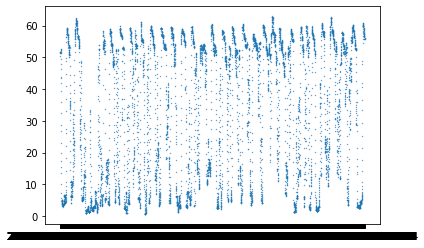

In [13]:
plt.scatter(some_id['DATA_AS_OF'], some_id['SPEED'], s=0.1)

In [24]:
first_day = some_id[some_id['DATA_AS_OF'].dt.date]
first_day.head()

,LINK_ID,DATA_AS_OF,SPEED


In [31]:
some_id[some_id['DATA_AS_OF'].dt.date == '2019-05-20']

,LINK_ID,DATA_AS_OF,SPEED


## Topic 2 <a class="anchor" id="topic-2"></a>
<hr/>

In [88]:
### read in data
cdata = pd.read_csv('../data_large/collisions.csv')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [94]:
cdata.shape

(1720022, 29)

In [103]:
cdata.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,10/09/2020,10:12,NaN,NaN,40.683933,-73.871190,"(40.683933, -73.87119)",HEMLOCK STREET,NaN,NaN,1.0,0.0,1,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,4356254,NaN,NaN,NaN,NaN,NaN
1,10/09/2020,15:40,NaN,NaN,NaN,NaN,NaN,HUTCHINSON RIVER PARKWAY,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4356784,Sedan,NaN,NaN,NaN,NaN
2,10/09/2020,2:00,NaN,NaN,NaN,NaN,NaN,STATEN ISLAND EXPRESSWAY,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4355987,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN
3,10/08/2020,10:46,NaN,NaN,40.827210,-73.920700,"(40.82721, -73.9207)",EAST 162 STREET,NaN,NaN,0.0,0.0,0,0,0,0,0,0,Failure to Yield Right-of-Way,Unspecified,NaN,NaN,NaN,4355967,Sedan,AMBU,NaN,NaN,NaN
4,10/08/2020,19:24,NaN,NaN,40.799310,-73.943245,"(40.79931, -73.943245)",PARK AVENUE,NaN,NaN,1.0,0.0,1,0,0,0,0,0,Driver Inexperience,NaN,NaN,NaN,NaN,4356130,Sedan,NaN,NaN,NaN,NaN


In [106]:
cdata.isnull().sum()

CRASH DATE                             0
CRASH TIME                             0
BOROUGH                           526355
ZIP CODE                          526564
LATITUDE                          205510
LONGITUDE                         205510
LOCATION                          205510
ON STREET NAME                    343816
CROSS STREET NAME                 596739
OFF STREET NAME                  1468574
NUMBER OF PERSONS INJURED             17
NUMBER OF PERSONS KILLED              31
NUMBER OF PEDESTRIANS INJURED          0
NUMBER OF PEDESTRIANS KILLED           0
NUMBER OF CYCLIST INJURED              0
NUMBER OF CYCLIST KILLED               0
NUMBER OF MOTORIST INJURED             0
NUMBER OF MOTORIST KILLED              0
CONTRIBUTING FACTOR VEHICLE 1       4733
CONTRIBUTING FACTOR VEHICLE 2     239060
CONTRIBUTING FACTOR VEHICLE 3    1606331
CONTRIBUTING FACTOR VEHICLE 4    1695836
CONTRIBUTING FACTOR VEHICLE 5    1713759
COLLISION_ID                           0
VEHICLE TYPE COD

In [107]:
cdata.columns

Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'],
      dtype='object')

In [108]:
drop_cols = ['OFF STREET NAME', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']
cdata.drop(columns=drop_cols, inplace=True)

In [109]:
cdata.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2
0,10/09/2020,10:12,NaN,NaN,40.683933,-73.871190,"(40.683933, -73.87119)",HEMLOCK STREET,NaN,1.0,0.0,1,0,0,0,0,0,NaN,NaN,4356254,NaN,NaN
1,10/09/2020,15:40,NaN,NaN,NaN,NaN,NaN,HUTCHINSON RIVER PARKWAY,NaN,0.0,0.0,0,0,0,0,0,0,Unspecified,NaN,4356784,Sedan,NaN
2,10/09/2020,2:00,NaN,NaN,NaN,NaN,NaN,STATEN ISLAND EXPRESSWAY,NaN,0.0,0.0,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,4355987,Station Wagon/Sport Utility Vehicle,NaN
3,10/08/2020,10:46,NaN,NaN,40.827210,-73.920700,"(40.82721, -73.9207)",EAST 162 STREET,NaN,0.0,0.0,0,0,0,0,0,0,Failure to Yield Right-of-Way,Unspecified,4355967,Sedan,AMBU
4,10/08/2020,19:24,NaN,NaN,40.799310,-73.943245,"(40.79931, -73.943245)",PARK AVENUE,NaN,1.0,0.0,1,0,0,0,0,0,Driver Inexperience,NaN,4356130,Sedan,NaN


In [110]:
cdata['BOROUGH'].value_counts(dropna=False)

NaN              526355
BROOKLYN         373066
QUEENS           319451
MANHATTAN        280531
BRONX            169930
STATEN ISLAND     50689
Name: BOROUGH, dtype: int64

In [100]:
# cdata['NUMBER OF PERSONS INJURED'].value_counts()

In [101]:
cdata['NUMBER OF PERSONS KILLED'].value_counts()

0.0    1717963
1.0       1968
2.0         47
3.0          8
4.0          3
8.0          1
5.0          1
Name: NUMBER OF PERSONS KILLED, dtype: int64

In [102]:
cdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1720022 entries, 0 to 1720021
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   CRASH DATE                     object 
 1   CRASH TIME                     object 
 2   BOROUGH                        object 
 3   ZIP CODE                       object 
 4   LATITUDE                       float64
 5   LONGITUDE                      float64
 6   LOCATION                       object 
 7   ON STREET NAME                 object 
 8   CROSS STREET NAME              object 
 9   OFF STREET NAME                object 
 10  NUMBER OF PERSONS INJURED      float64
 11  NUMBER OF PERSONS KILLED       float64
 12  NUMBER OF PEDESTRIANS INJURED  int64  
 13  NUMBER OF PEDESTRIANS KILLED   int64  
 14  NUMBER OF CYCLIST INJURED      int64  
 15  NUMBER OF CYCLIST KILLED       int64  
 16  NUMBER OF MOTORIST INJURED     int64  
 17  NUMBER OF MOTORIST KILLED      int64  
 18  CO

In [117]:
cdata_man = cdata[cdata['BOROUGH']=='MANHATTAN'].copy()

In [118]:
cdata_man.shape

(280531, 22)

In [119]:
cdata_man.columns

Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
       'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
       'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
       'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED',
       'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2'],
      dtype='object')

In [120]:
cdata_man.isna().sum()

CRASH DATE                           0
CRASH TIME                           0
BOROUGH                              0
ZIP CODE                            15
LATITUDE                          8692
LONGITUDE                         8692
LOCATION                          8692
ON STREET NAME                   44356
CROSS STREET NAME                44423
NUMBER OF PERSONS INJURED            3
NUMBER OF PERSONS KILLED             6
NUMBER OF PEDESTRIANS INJURED        0
NUMBER OF PEDESTRIANS KILLED         0
NUMBER OF CYCLIST INJURED            0
NUMBER OF CYCLIST KILLED             0
NUMBER OF MOTORIST INJURED           0
NUMBER OF MOTORIST KILLED            0
CONTRIBUTING FACTOR VEHICLE 1      991
CONTRIBUTING FACTOR VEHICLE 2    38359
COLLISION_ID                         0
VEHICLE TYPE CODE 1               1518
VEHICLE TYPE CODE 2              38345
dtype: int64

In [121]:
cdata_man.drop(columns=['ON STREET NAME', 'CROSS STREET NAME', 'CONTRIBUTING FACTOR VEHICLE 2','VEHICLE TYPE CODE 2'], inplace=True)

In [124]:
cdata_man.dropna(axis=0, inplace=True)

In [125]:
cdata_man.shape

(269758, 18)

In [126]:
cdata_man.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,COLLISION_ID,VEHICLE TYPE CODE 1
32,09/24/2020,16:36,MANHATTAN,10128,40.783245,-73.94473,"(40.783245, -73.94473)",1.0,0.0,1,0,0,0,0,0,Failure to Yield Right-of-Way,4351409,Taxi
386,05/06/2020,0:00,MANHATTAN,10128,40.780170,-73.95510,"(40.78017, -73.9551)",0.0,0.0,0,0,0,0,0,0,Unspecified,4312162,Sedan
437,10/02/2020,19:00,MANHATTAN,10128,40.781372,-73.94820,"(40.781372, -73.9482)",0.0,0.0,0,0,0,0,0,0,Following Too Closely,4355018,Sedan
438,09/11/2020,14:41,MANHATTAN,10030,40.818714,-73.94199,"(40.818714, -73.94199)",0.0,0.0,0,0,0,0,0,0,Other Vehicular,4348117,Sedan
444,08/20/2020,8:30,MANHATTAN,10025,40.799140,-73.96472,"(40.79914, -73.96472)",0.0,0.0,0,0,0,0,0,0,Unspecified,4340329,Station Wagon/Sport Utility Vehicle


In [128]:
cdata_man.isna().sum()

CRASH DATE                       0
CRASH TIME                       0
BOROUGH                          0
ZIP CODE                         0
LATITUDE                         0
LONGITUDE                        0
LOCATION                         0
NUMBER OF PERSONS INJURED        0
NUMBER OF PERSONS KILLED         0
NUMBER OF PEDESTRIANS INJURED    0
NUMBER OF PEDESTRIANS KILLED     0
NUMBER OF CYCLIST INJURED        0
NUMBER OF CYCLIST KILLED         0
NUMBER OF MOTORIST INJURED       0
NUMBER OF MOTORIST KILLED        0
CONTRIBUTING FACTOR VEHICLE 1    0
COLLISION_ID                     0
VEHICLE TYPE CODE 1              0
dtype: int64

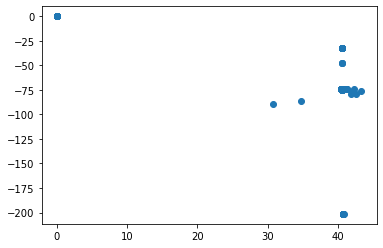

In [131]:
plt.scatter(cdata['LATITUDE'], cdata['LONGITUDE'])